In [1]:
import os 
import json
from PIL import Image, ImageDraw, ImageFont
from sys import exit
from snapshot_status import getStatus
from getBoardID import get_board_ids, get_board_ids_all
import gif_builder
import player_statistics
from BuildNewGlyph import *
import glob
from copy import copy, deepcopy
from datetime import datetime
from itertools import chain
import Constants

[INFO] Started!
True


### Without any form of abstraction : Go Through each log file and find absolute boards. Two board states are equal if and only if every link, semaphore and singal exactly align

In [2]:
default_elements_names= {
    "13":{
        "L_dragonfruit_5001":"default_switch"
    }
}

default_elements = {
    
                    "10":{
                        "L_coconut_5002":(6,10),
                        "L_coconut_5001":(8,4)
                    },
                    "13":{"L_dragonfruit_5001":(4,12)},
                    
                    "15":{
                        "L_fig_5002":(6,2),
                        "L_fig_5003":(6,10),
                        "L_fig_5001":(3,6),
                        "L_fig_4006":(8,12),
                        "L_fig_4005":(12,8),
                        "L_fig_4004":(8,8),
                        "L_fig_4003":(12,4),
                        "L_fig_4002":(8,4),
                        "L_fig_4001":(12,0),
                        "L_fig_3001":(12,12),
                        "L_fig_2001":(7,0)
                        
                    }
                    }

#load level log files
log_files = "../DATA/LEVEL_13_LOGS"
level = 13

#map data  level 13 -> 8 rows 16 columns
level_13_rows = 8
level_13_columns = 16

CRITICAL_EVENTS=[
    "BEGIN_LEVEL_LOAD",
    'ADD_ELEMENT',
    'MOVE_ELEMENT',
    'TOGGLE_ELEMENT',
    'REMOVE_ELEMENT',
    'BEGIN_LINK',
]

In [3]:
states = {}
total_players = 0
total_actions = 0
for file in os.listdir(log_files):
    total_players+=1
    empty_semaphore_matrix = [[0 for j in range(0,level_13_columns+1)] for i in range(0,level_13_rows+1)]
    empty_signal_matrix = [[0 for j in range(0,level_13_columns+1)] for i in range(0,level_13_rows+1)]
    empty_link_matrix = [[0 for j in range(0,level_13_columns+1)] for i in range(0,level_13_rows+1)]
    empty_toggled_matrix = [[0 for j in range(0,level_13_columns+1)] for i in range(0,level_13_rows+1)]
    board_state = {} 
    user = file.split('.')[0]
    states[user] = {} 
    fileName = log_files+'/'+file            
    data = json.load(open(fileName))
    
    for index,event in enumerate(data['events']):
        
        if event['type'] == 'ADD_ELEMENT':
            total_actions+=1
            element_id   = event['element']['id']     #element id
            element_type = event['element']['type']   #semaphore, signal

            element_x = event['element']['cell'][0] #x
            element_y = event['element']['cell'][1] #y
            
            if element_type == 'signal':
                board_state[element_id] = {
                    "type":element_type,
                    "element_x":element_x,
                    "element_y":element_y,
                    "link":None
                }
                empty_signal_matrix[element_x][element_y]+=1
            if element_type == 'semaphore':
                board_state[element_id] = {
                    "type":element_type,
                    "element_x":element_x,
                    "element_y":element_y,
                    "status":'inactive'
                }
                empty_semaphore_matrix[element_x][element_y]+=1

        if event['type'] == 'MOVE_ELEMENT':
            total_actions+=1
            element_id   = event['element']['id']  #element id
            

            old_x = board_state[element_id]['element_x'] 
            old_y = board_state[element_id]['element_y']
            
            new_x = event['element']['cell'][0] #x
            new_y = event['element']['cell'][1] #y
        
            board_state[element_id]['element_x']=new_x
            board_state[element_id]['element_y']=new_y
            
            if (new_x,new_y) != (old_x,old_y):
                board_state[element_id]['element_x']=new_x
                board_state[element_id]['element_y']=new_y

            if board_state[element_id]['type'] == "signal":
                empty_signal_matrix[old_x][old_y]=-1
                empty_signal_matrix[new_x][new_y]=+1
            if board_state[element_id]['type'] == "semaphore":
                empty_semaphore_matrix[old_x][old_y]=-1
                empty_semaphore_matrix[new_x][new_y]=+1

                
                #if the element is connected and being moved it is an interesting move and we want to flag!
                if board_state[element_id]["type"]=="signal": #if I am moving a signal
                    if board_state[element_id]['link']!=None: # if the signal I am moving has a link 
                        moving_connected_elements=True
                        element_2_id = board_state[element_id]['link']
                        try:
                            element_2_x =  board_state[element_2_id]['element_x']               
                            element_2_y =  board_state[element_2_id]['element_y']
                            #if element_2 not in board state and is possibly a default element
                        except:
                            element_2_x = default_elements[str(level)][element_2_id][0]
                            element_2_y = default_elements[str(level)][element_2_id][1]


                        
                        empty_link_matrix[old_x][old_y]-=1
                        empty_link_matrix[new_x][new_y]-=1


                elif board_state[element_id]["type"]=="semaphore":#I am moving a semaphore
                    for item in board_state:
                        if board_state[item]['type']=='signal': #searching through signals if the semaphore is linked
                            try:
                                if board_state[item]['link']==element_id: #Found a signal linked to the semaphore
                                    moving_connected_elements=True
                                    element_2_x =  board_state[item]['element_x']               
                                    element_2_y =  board_state[item]['element_y']

                                    empty_link_matrix[old_x][old_y]-=1
                                    empty_link_matrix[new_x][new_y]-=1

                                else:
                                    pass

                            except:
                                pass
   
        if event['type']=='TOGGLE_ELEMENT':
            total_actions+=1
            element_id   = event['element']['id']  #element id
            toggled_x  = board_state[element_id]['element_x']
            toggled_y  = board_state[element_id]['element_y']
            empty_toggled_matrix[toggled_x][toggled_y]+=1
            

        if event['type'] == 'REMOVE_ELEMENT':
            total_actions+=1
            element_id = event['element']['id']
            element_type = event['element']['type']
            removed_element_x = board_state[element_id]['element_x'] 
            removed_element_y = board_state[element_id]['element_y']
            if element_type == "signal":
                empty_signal_matrix[removed_element_x][removed_element_y]-=1
            if element_type == "semaphore":
                empty_semaphore_matrix[removed_element_x][removed_element_y]-=1

            board_state.pop(element_id)

            if empty_link_matrix[removed_element_x][removed_element_y]>0:
                empty_link_matrix[removed_element_x][removed_element_y]=-1

        
        if event['type'] == 'BEGIN_LINK':
            total_actions+=1
            element_1_id = event['element']['id']
            if data['events'][index+1]['type']=='FINISH_LINK':
                total_actions+=1
                element_2_id = data['events'][index+1]['element']['id']   
                board_state[element_1_id]['link']=element_2_id
                try:
                    element_2_x =  board_state[element_2_id]['element_x']               
                    element_2_y =  board_state[element_2_id]['element_y']
                    #if element_2 not in board state and is possibly a default element
                except:
                    element_2_x = default_elements[str(level)][element_2_id][0]
                    element_2_y = default_elements[str(level)][element_2_id][1]
                element_1_x = board_state[element_1_id]['element_x']
                element_1_y = board_state[element_1_id]['element_y']

                empty_link_matrix[element_1_x][element_y]+=1
                empty_link_matrix[element_2_x][element_2_y]+=1                                      

            elif data['events'][index+2]['type']=='FINISH_LINK':
                total_actions+=1
                element_2_id = data['events'][index+2]['element']['id']
                board_state[element_1_id]['link']=element_2_id
                try:
                    element_2_x =  board_state[element_2_id]['element_x']               
                    element_2_y =  board_state[element_2_id]['element_y']
                    #if element_2 not in board state and is possibly a default element
                except:
                    element_2_x = default_elements[str(level)][element_2_id][0]
                    element_2_y = default_elements[str(level)][element_2_id][1]

                element_1_x = board_state[element_1_id]['element_x']
                element_1_y = board_state[element_1_id]['element_y']
                empty_link_matrix[element_1_x][element_y]+=1
                empty_link_matrix[element_2_x][element_2_y]+=1                                      

                    
            else:
                pass
            
                
        

        if event['type'] in CRITICAL_EVENTS:
            states[user]=states.get(user,{})  
            entry_1 = deepcopy(empty_signal_matrix) 
            entry_2 = deepcopy(empty_semaphore_matrix)   
            entry_3 = deepcopy(empty_link_matrix)
            entry_4 = deepcopy(empty_toggled_matrix)              
            states[user][event['id']]={
                'event_type':event['type'],
                'signal_matrix' : entry_1,
                'semaphore_matrix' : entry_2,
                'link_matrix': entry_3,
                'toggle_matrix':entry_4,
                'total': entry_1+entry_2+entry_3+entry_4
                }


unique_states = []
for player in states:
    player_data = states[player]
    for action in player_data:
        action_type = player_data[action]['event_type']
        sempahore_matrix = list(chain.from_iterable(player_data[action]['semaphore_matrix']))        
        signal_matrix    = list(chain.from_iterable(player_data[action]['signal_matrix']))
        link_matrix      = list(chain.from_iterable(player_data[action]['link_matrix']))
        toggle_matrix      = list(chain.from_iterable(player_data[action]['toggle_matrix']))

        board            = sempahore_matrix + signal_matrix + link_matrix + toggle_matrix
        if board not in unique_states:
            unique_states.append(board)


print("Number of Players: ", total_players)
print("Number of User actions: ", total_actions)
print("Total Unique Board States: ",len(unique_states))     

Number of Players:  16
Number of User actions:  1066
Total Unique Board States:  237


### Abstraction and Cosine similarity + Knowledge

In [4]:
import os 
import json
from PIL import Image, ImageDraw, ImageFont
from sys import exit
from snapshot_status import getStatus
from getBoardID import get_board_ids
import gif_builder
import player_statistics
from BuildNewGlyph import *
import glob
from copy import copy, deepcopy
from datetime import datetime

SCREENSHOT_BLOCKS = '../DATA/ScreenshotData'
log_files = "../DATA/LEVEL_13_LOGS"
level = 13
SCREENSHOT_FLAG = False
GIF_FLAG        = False





class StateShot:
    def __init__(self,board_state,fileName,text,level,user,eventType=None):
        self.board_state = board_state
        self.fileName    = fileName
        self.text        = text
        self.level       = level
        self.user       = user  

        self.preImage = Image.open(f'{SCREENSHOT_BLOCKS}/order{self.level}.png')
        self.destination = f'../DATA/IntermediateScreenShots/{self.user}/{fileName}.png'
        self.destination_2 = f'../DATA/Screenshots/{self.user}/{fileName}.png'
        self.font = ImageFont.truetype("Roboto-Bold.ttf",size=45)
        self.text_color =  'rgb(255, 255, 255)'
        self.event_type = eventType
        self.stateMatrix = None
        
    def drawSemaphore(self,x,y,status):
        location = [x,y]
        # edited for the active and inactive semaphore @@@
        if status=="inactive":
            semaphore = Image.open('../DATA/ScreenshotData/semaphoreInactive.png','r')
        else:
            semaphore = Image.open('../DATA/ScreenshotData/semaphoreActive.png','r')
        self.preImage.paste(semaphore, (location[1]*100, location[0]*100), mask=semaphore)
    def drawSignal(self, x,y):
        location = [x,y]
        semaphore = Image.open('../DATA/ScreenshotData/signalInactive.png','r')
        self.preImage.paste(semaphore, (location[1]*100, location[0]*100), mask=semaphore)
    def drawLink(self,x,y,x1,y1):
        location0 = [x,y]
        location1 = [x1,y1]
        draw = ImageDraw.Draw(self.preImage)
        draw.line((location0[1]*100+50, location0[0]*100+50, location1[1]*100+50, location1[0]*100+50), width = 5, fill='yellow')
    def drawText(self,text):
        (x, y) = (500, 850)
        draw = ImageDraw.Draw(self.preImage)
        draw.text((x, y), text, fill=self.text_color,font=self.font)
    def saveImage(self):
        self.preImage.save(self.destination, quality=95)
        if self.event_type=='BOARD_SNAPSHOT':
            self.preImage.save(self.destination_2, quality=95)
            

    def buildScreenShot(self):
        for item in self.board_state:
            if self.board_state[item]['type']=="semaphore":
                self.drawSemaphore(self.board_state[item]["element_x"],self.board_state[item]["element_y"],self.board_state[item]['status'])
            if self.board_state[item]['type']=="signal":
                self.drawSignal(self.board_state[item]["element_x"],self.board_state[item]["element_y"])
                if self.board_state[item]['link']!=None:
                    link_id=self.board_state[item]['link']
                    try:
                        self.drawLink(
                            self.board_state[item]["element_x"],
                            self.board_state[item]["element_y"], 
                            self.board_state[link_id]["element_x"],
                            self.board_state[link_id]["element_y"],

                        )
                    except:
                        print('[INFO] This is a default element!')
                        self.drawLink(
                            self.board_state[item]["element_x"],
                            self.board_state[item]["element_y"], 
                            default_elements[str(self.level)][link_id][0],
                            default_elements[str(self.level)][link_id][1],
                        )
                            
        self.drawText(self.text)
        self.saveImage()


class Abstraction:
    def __init__(self,level,board_state):
        self.level = str(level)
        self.zoneSheet = f'../DATA/maps_with_zones/MapInfo_{self.level}.json'
        self.level_info      = json.load(open(self.zoneSheet))
        self.zones         =   self.level_info[self.level]['mapAreas']      
        self.index         = 0
        self.indexMap      = {}
        self.nSemaphores   = 0
        self.nSignals      = 0
        
        #cordinates
        self.semaphorePositions = [] #(id,x,y,zone) 
        self.signalPositions    = [] #(id,x,y,zone)
        self.linkPositions      = [] #(position1,postion2)        
        #abstraction 1
        self.semaphore_zone_dict = {}
        self.signal_zone_dict    = {}
        self.link_dict           = {} #{"zone1zone2" : count}
        
        for zone in self.zones:
            self.indexMap[zone]=self.index
            self.index+=1
        
        self.indexMap["semaphore_row"]=self.index
        self.index+=1
        self.indexMap["signal_row"]=self.index
        
        self.adjaceny_matrix = [[0 for j in range(len(self.zones))] for i in range(len(self.zones)) ]  

        
    def getSemaphoreXY(self,id):
        if id==None:
            return (None,None)
        
        for semaphore in self.semaphorePositions:
            if semaphore[0]==id:
                return (semaphore[1],semaphore[2]) 
        return (None,None)
    def getSignalXY(self,id):
        for signal in self.signalPositions:
            if signal[0]==id:
                return signal[1],signal[2]
        return None
    def putSemaphore(self,x,y,id,status):
        zone  = self.getZone(x,y)
        if zone in self.semaphore_zone_dict:
            self.semaphore_zone_dict[zone]+=1
        else:
            self.semaphore_zone_dict[zone]=1
        #add the element to the board
        self.semaphorePositions.append((id,x,y,zone))
        #update the counts
        self.nSemaphores+=1

    def zoneIndex(self,zone):
        return self.indexMap[zone]
    def putSignal(self,x,y,id_1,id_2):
        #print(x,y)
        zone  = self.getZone(x,y)
        if zone in self.signal_zone_dict:
            self.signal_zone_dict[zone]+=1
        else:
            self.signal_zone_dict[zone]=1
        #print(f'[INFO] adding {id_1} to signal positions')
        self.signalPositions.append((id_1,x,y,zone))
        self.nSignals+=1
        #populate link dict
        (connection_x,connection_y) = self.getSemaphoreXY(id_2)
        if connection_x!=None:
            #print(connection_x,connection_y)
            #print(self.getZone(connection_x,connection_y),zone)
            key  = zone + self.getZone(connection_x,connection_y)
            if key in self.link_dict:
                self.link_dict[key]+=1
            else:
                self.link_dict[key]=1

            self.adjaceny_matrix[self.zoneIndex(zone)][self.zoneIndex(self.getZone(connection_x,connection_y))]+=1
            self.linkPositions.append([x,y,connection_x,connection_y])
        else:
            # print('[INFO] This signal could not find a semaphore!')
            # print('[INFO] This could be a link between a signal and a Default element!')
            # print('[INFO] Attempting to search in default elements')
            pass

            if id_2!=None:
                (connection_x,connection_y) = default_elements[str(self.level)][id_2]
                if connection_x!=None:
                    #print('[INFO] Yes! Default element found!')
                    key  = zone + self.getZone(connection_x,connection_y)
                    if key in self.link_dict:
                        self.link_dict[key]+=1
                    else:
                        self.link_dict[key]=1
                    
                    self.adjaceny_matrix[self.zoneIndex(zone)][self.zoneIndex(self.getZone(connection_x,connection_y))]+=1
                    self.linkPositions.append([x,y,connection_x,connection_y])
                else:
                    pass
                    #print("===================CONNECTION NOT FOUND IN DEFAULT ELEMENTS TOO!") 
                    
    #returns which zone a point belongs to 
    def getZone(self,x,y):
        query = [x,y]
        for zone in self.zones:
            if query in self.zones[zone]:
                return zone 
        return None
    
    def getAdjacencyMatrix(self):
        return self.adjaceny_matrix 
    
    def getAbstraction(self):
        abstraction = {
            'nSemaphores'     : self.nSemaphores,
            'nSignals'        : self.nSignals,
            'semaphore_zone_dict':self.semaphore_zone_dict,
            'signal_zone_dict':self.signal_zone_dict,
            'link_dict':self.link_dict,
        }
        return abstraction

    def getStateMatrix(self):
        semaphore_row = []
        signal_row    = []
        for zone in self.zones:
            if zone in self.semaphore_zone_dict:
                #print(zone,"+1")
                semaphore_row.append(self.semaphore_zone_dict[zone])
            else:
                semaphore_row.append(0)
            if zone in self.signal_zone_dict:
                signal_row.append(self.signal_zone_dict[zone])
            else:
                signal_row.append(0)
        
        
        self.stateMatrix = deepcopy(self.adjaceny_matrix)

        self.stateMatrix.append(semaphore_row)
        self.stateMatrix.append(signal_row)

        return self.stateMatrix               
     
def buildAbstraction(level,board_state):
    abstraction = Abstraction(level,board_state)
    for item in board_state:
        if board_state[item]['type']=="semaphore":
            abstraction.putSemaphore(board_state[item]['element_x'],
                                     board_state[item]['element_y'],
                                     item,
                                     board_state[item]['status'])
    
    for item in board_state:        
        if board_state[item]['type']=='signal':
            abstraction.putSignal(board_state[item]['element_x'],
                                  board_state[item]['element_y'],
                                  item,
                                  board_state[item]['link'])

    return abstraction.getAbstraction(),abstraction.getAdjacencyMatrix(),abstraction.getStateMatrix()       
        
        
CRITICAL_EVENTS=[
    "BEGIN_LEVEL_LOAD",
    'ADD_ELEMENT',
    'MOVE_ELEMENT',
    'TOGGLE_ELEMENT',
    'REMOVE_ELEMENT',
    'BEGIN_LINK',
]
player_traces = {}
total_number_of_nodes = 0 
total_number_of_begin_links = 0
abstraction_object = Abstraction(level,{})

for file in os.listdir(log_files):
    user = file.split('.')[0]
    fileName = log_files+'/'+file
    board_state = {}
    
    order_change_events_behaviour = False
    same_zone_linking = False
    moving_connected_elements = False
    store_in_trace = True
    
    knowledge_statement = "No Knowledge Statement"
    
    
    
    try:
        os.mkdir(f'../DATA/IntermediateScreenShots/{user}')
        os.mkdir(f'../DATA/Screenshots/{user}')
    except:
        pass
        
    board_snapshot_ticks = "No Ticks Available"
    #print(fileName)
    data = json.load(open(fileName))
    for index,event in enumerate(data['events']):    
        if event['type'] in CRITICAL_EVENTS or event['type']=="BOARD_SNAPSHOT":
            total_number_of_nodes+=1
        if event['type']=="BEGIN_LEVEL_LOAD":
            board_state = {}
            if SCREENSHOT_FLAG:
                stateShot = StateShot(board_state,f"{index}_{event['id']}","LEVEL RESTARTED",level,user) 
                stateShot.buildScreenShot()
    
        if event['type'] == 'ADD_ELEMENT':
            element_id   = event['element']['id']     #element id
            element_type = event['element']['type'] #semaphore, signal
            element_x = event['element']['cell'][0] #x
            element_y = event['element']['cell'][1] #y
            if element_type == 'signal':
                board_state[element_id] = {
                    "type":element_type,
                    "element_x":element_x,
                    "element_y":element_y,
                    "link":None
                }
            if element_type == 'semaphore':
                board_state[element_id] = {
                    "type":element_type,
                    "element_x":element_x,
                    "element_y":element_y,
                    "status":'inactive'
                }
                
            #print('[INFO] Element Added',element_id)
            
            if SCREENSHOT_FLAG:            
                #CALL SCREEENSHOT on board_state
                stateShot = StateShot(board_state,f"{index}_{event['id']}",event['type'],level,user) 
                stateShot.buildScreenShot()
                                    
        if event['type'] == 'MOVE_ELEMENT':
            element_id   = event['element']['id']  #element id
            
            old_x = board_state[element_id]['element_x'] 
            old_y = board_state[element_id]['element_y']
            old_zone = abstraction_object.getZone(old_x,old_y)
            
            new_x = event['element']['cell'][0] #x
            new_y = event['element']['cell'][1] #y
            new_zone = abstraction_object.getZone(new_x,new_y)
            #print(f"Element moved form {new_zone}, {old_zone},{(new_x,new_y)},{(old_x,old_y)}")
            
            if (new_x,new_y) != (old_x,old_y):
                #print(f"#################### Element moved form {new_zone}, {old_zone},{(new_x,new_y)},{(old_x,old_y)}")                
                #update to new coordinates
                board_state[element_id]['element_x']=new_x
                board_state[element_id]['element_y']=new_y
                
                #print('[INFO] Element Moved',element_id)
                
                if new_zone == old_zone:
                    order_change_events_behaviour=True
                #if the element is connected and being moved it is an interesting move and we want to flag!
                if board_state[element_id]["type"]=="signal":
                    if board_state[element_id]['link']!=None:
                        moving_connected_elements=True
                        #print('[FLAGGGGG] The User is moving a connected element!!!!!')
                        
                elif board_state[element_id]["type"]=="semaphore":
                    for item in board_state:
                        if board_state[item]['type']=='signal':
                            try:
                                if board_state[item]['link']==element_id:
                                    moving_connected_elements=True
                                    #print('[FLAGGGGG] The User is moving a connected element!!!!!')
                            except:
                                pass
                            
                #CALL SCREENSHOT on board_state
                if SCREENSHOT_FLAG:
                    stateShot = StateShot(board_state,f"{index}_{event['id']}",event['type'],level,user) 
                    stateShot.buildScreenShot()

            else:
                #print('[INFOOOOOO] ############ ahaa did not actually move hence not adding to trace')
                store_in_trace = False
            
        if event['type'] == 'TOGGLE_ELEMENT':
            element_id   = event['element']['id']  #element id
            board_state[element_id]['status']=event['element']['spec']

            #print('[INFO] Element Toggled',element_id)
            
            if SCREENSHOT_FLAG:
                #CALL SCREENSHOT on board_state
                stateShot = StateShot(board_state,f"{index}_{event['id']}",event['type'],level,user) 
                stateShot.buildScreenShot()

        if event['type'] == 'REMOVE_ELEMENT':
            element_id = event['element']['id']         
            board_state.pop(element_id)
            #print('[INFO] Element Removed',element_id,file)            

            #if you are deleting a semaphore 
            # you want to delete the signal link
            for item in board_state:
                if board_state[item]['type']=='signal':
                    try:
                        if board_state[item]['link']==element_id:
                            board_state[item]['link']=None
                            #print(f'[INFO] Element Link Removed {element_id} and {item}',)            

                    except:
                        pass

                    
                            
                
            if SCREENSHOT_FLAG:
                #CALL SCREENSHOT
                stateShot = StateShot(board_state,f"{index}_{event['id']}",event['type'],level,user) 
                stateShot.buildScreenShot()
               
        if event['type'] == 'BEGIN_LINK':
            total_number_of_begin_links+=1
            #print('[INFO] Adding a Link')
            element_1_id = event['element']['id']
            #print('[INFO] Adding a Link',element_1_id)
            if data['events'][index+1]['type']=='FINISH_LINK':
                element_2_id = data['events'][index+1]['element']['id']
                #print(f"ADDING LINK : {element_1_id},{element_2_id}")    
                board_state[element_1_id]['link']=element_2_id
                try:
                    element_2_x =  board_state[element_2_id]['element_x']               
                    element_2_y =  board_state[element_2_id]['element_y']
                    #if element_2 not in board state and is possibly a default element
                except:
                    element_2_x = default_elements[str(level)][element_2_id][0]
                    element_2_y = default_elements[str(level)][element_2_id][1]
                element_1_x = board_state[element_1_id]['element_x']
                element_1_y = board_state[element_1_id]['element_y']
                
                element_2_zone = abstraction_object.getZone(element_2_x,element_2_y)
                element_1_zone = abstraction_object.getZone(element_1_x,element_1_y) 
                
                if element_2_zone == element_1_zone:
                    #print("####[INFO] Connection Appears to be from the Same Zone! Flagging!###")
                    same_zone_linking = True
                    
                #print(f"########################ADDING LINK : {element_1_id},{element_2_id},{element_2_zone},{element_1_zone}")
                                                       

            elif data['events'][index+2]['type']=='FINISH_LINK':
                element_2_id = data['events'][index+2]['element']['id']
                #print(f"ADDING LINK : {element_1_id},{element_2_id}")    
                board_state[element_1_id]['link']=element_2_id
                try:
                    element_2_x =  board_state[element_2_id]['element_x']               
                    element_2_y =  board_state[element_2_id]['element_y']
                    #if element_2 not in board state and is possibly a default element
                except:
                    element_2_x = default_elements[str(level)][element_2_id][0]
                    element_2_y = default_elements[str(level)][element_2_id][1]

                element_1_x = board_state[element_1_id]['element_x']
                element_1_y = board_state[element_1_id]['element_y']
                
                element_2_zone = abstraction_object.getZone(element_2_x,element_2_y)
                element_1_zone = abstraction_object.getZone(element_1_x,element_1_y) 
                if element_2_zone == element_1_zone:
                    #print("####[INFO] Connection Appears to be from the Same Zone! Flagging!###")
                    same_zone_linking = True
                    
                #print(f"ADDING LINK : {element_1_id},{element_2_id},{element_2_zone},{element_1_zone}")
            else:
                pass
                #print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!![ERROR] Could Not find Finish Link!')
                #print('[INFO] Either CODE needs fix or the log file is corrupted')
                #print(file)
            
            knowledge_statement=f"Adding Link:{element_1_zone}:{element_2_zone}"
            #print(knowledge_statement)

            #CALL SCREENSHOT            
            if SCREENSHOT_FLAG:
                stateShot = StateShot(board_state,f"{index}_{event['id']}",event['type'],level,user) 
                stateShot.buildScreenShot()
        
        if event['type'] == 'FINISH_SIMULATION':
            board_snapshot_ticks = event['total']
        
        if event['type']=='BOARD_SNAPSHOT':
            #No element manipulation 
            # so just Build the screenshot
            if SCREENSHOT_FLAG:
                text  = getStatus(event['id'],f"{user}"+".json")                    
                stateShot = StateShot(board_state,f"{index}_{event['id']}",text,level,user,event['type']) 
                stateShot.buildScreenShot()
           
        #Calling Abstraction
        if store_in_trace:
            if event['type'] in CRITICAL_EVENTS:                   
                abstraction,adjacency_matrix,state_matrix =  buildAbstraction(level,board_state)
                if user in player_traces:
                    player_traces[user][event['id']]={
                        "id":event['id'],
                        "type":event['type'],
                        "screenshot":f"{index}_{event['id']}.png",
                        "absolute_board_state":board_state.copy(),
                        "abstracted_board_state":abstraction,
                        "adjacency_matrix":adjacency_matrix,
                        "state_matrix":state_matrix,
                        "discussion":[],
                        "upvotes":0,
                        "knowledge_statement":knowledge_statement,
                        "created": event['created']
                    }
                else:
                    player_traces[user]={}
                    player_traces[user][event['id']]={
                        "id":event['id'],
                        "type":event['type'],
                        "screenshot":f"{index}_{event['id']}.png",
                        "absolute_board_state":board_state.copy(),
                        "abstracted_board_state":abstraction,
                        "adjacency_matrix":adjacency_matrix, 
                        "state_matrix":state_matrix,                   
                        "discussion":[],
                        "upvotes":0,
                        "knowledge_statement":knowledge_statement,
                        "created":event['created']

                    }
            
            if event['type']=='BOARD_SNAPSHOT':                   
                abstraction,adjacency_matrix,state_matrix =  buildAbstraction(level,board_state)
                if user in player_traces:
                    player_traces[user][event['id']]={
                        "id":event['id'],
                        "type":event['type'],
                        "screenshot":f"{index}_{event['id']}.png",
                        "absolute_board_state":board_state.copy(),
                        "abstracted_board_state":abstraction,
                        "adjacency_matrix":adjacency_matrix,
                        "state_matrix":state_matrix,                    
                        "discussion":[],
                        "upvotes":0,
                        "created": event['created'],
                        "submission_result" : getStatus(event['id'],f"{user}"+".json"),
                        "ticks":board_snapshot_ticks,
                        "no_order_change_behaviour_issue":order_change_events_behaviour,
                        "same_zone_linking":same_zone_linking,
                        "knowledge_statement":knowledge_statement,
                        "moving_connected_elements":moving_connected_elements
                    }
                else:
                    player_traces[user]={}
                    player_traces[user][event['id']]={
                        "id":event['id'],
                        "type":event['type'],
                        "screenshot":f"{index}_{event['id']}.png",
                        "absolute_board_state":board_state.copy(),
                        "abstracted_board_state":abstraction,
                        "adjacency_matrix":adjacency_matrix,
                        "state_matrix":state_matrix,
                        "discussion":[],
                        "upvotes":0,
                        "created":event['created'],
                        "submission_result" : getStatus(event['id'],f"{user}"+".json"),
                        "ticks":board_snapshot_ticks,
                        "no_order_change_behaviour_issue":order_change_events_behaviour,
                        "same_zone_linking":same_zone_linking,
                        "knowledge_statement":knowledge_statement,
                        "moving_connected_elements":moving_connected_elements
                    }
            
                board_snapshot_ticks = "No Ticks Available"
                order_change_events_behaviour = False
                same_zone_linking=False
                moving_connected_elements = False
                knowledge_statement="No Knowledge Statement",
        
        store_in_trace = True

#BUILD GLYPH Visualization
print('[INFO] Building Glyph Visualization')



cosine_ts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for cosine in cosine_ts:
    userStates = {}
    userActions = {} 
    usermap = {}
    for player in player_traces:
        board_snapshot_abstractions = []
        for event in player_traces[player]:
            # if player_traces[player][event]['type']=='BOARD_SNAPSHOT' or player_traces[player][event]['type'] in CRITICAL_EVENTS:
            #     board_snapshot_abstractions.append({"state_matrix":player_traces[player][event]["state_matrix"]})
            if player_traces[player][event]['type']=='BEGIN_LINK':
                board_snapshot_abstractions.append({"state_matrix":player_traces[player][event]["state_matrix"]})
            
        if len(board_snapshot_abstractions)>1:
            userStates[f"{player}.json"]=board_snapshot_abstractions
            userActions[f"{player}.json"]=["Recieved Next State"]*(len(userStates[f"{player}.json"])-1 )     
            userboardids=get_board_ids(log_files) 


    for user in player_traces:
        usermap[user+'.json']=user+'.json'

    filename = 'testing'
    glyphBuilder = GlyphBuilder(userStates, userActions, userboardids, f'{filename}.json',usermap,cosine)
    glyphBuilder.run()



print('[INFO] GLYPH Visualizatoin Built and saved')



[INFO] Building Glyph Visualization
The total number of nodes in abstracted glyph is for cosine value 0.1:  7
The total number of nodes in abstracted glyph is for cosine value 0.2:  7
The total number of nodes in abstracted glyph is for cosine value 0.3:  8
The total number of nodes in abstracted glyph is for cosine value 0.4:  11
The total number of nodes in abstracted glyph is for cosine value 0.5:  13
The total number of nodes in abstracted glyph is for cosine value 0.6:  16
The total number of nodes in abstracted glyph is for cosine value 0.7:  19
The total number of nodes in abstracted glyph is for cosine value 0.8:  30
The total number of nodes in abstracted glyph is for cosine value 0.9:  43
The total number of nodes in abstracted glyph is for cosine value 1.0:  54
[INFO] GLYPH Visualizatoin Built and saved


### Abstraction without Knowledge

In [5]:

cosine_ts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for cosine in cosine_ts:
    userStates = {}
    userActions = {} 
    usermap = {}
    for player in player_traces:
        board_snapshot_abstractions = []
        for event in player_traces[player]:
            if player_traces[player][event]['type']=='BOARD_SNAPSHOT' or player_traces[player][event]['type'] in CRITICAL_EVENTS:
                board_snapshot_abstractions.append({"state_matrix":player_traces[player][event]["state_matrix"]})
            # if player_traces[player][event]['type']=='BEGIN_LINK':
            #     board_snapshot_abstractions.append({"state_matrix":player_traces[player][event]["state_matrix"]})
            
        if len(board_snapshot_abstractions)>1:
            userStates[f"{player}.json"]=board_snapshot_abstractions
            userActions[f"{player}.json"]=["Recieved Next State"]*(len(userStates[f"{player}.json"])-1 )   
            userboardids=get_board_ids_all(log_files) 

    

    for user in player_traces:
        usermap[user+'.json']=user+'.json'

    filename = 'testing'
    glyphBuilder = GlyphBuilder(userStates, userActions, userboardids, f'{filename}.json',usermap,cosine)
    glyphBuilder.run()



print('[INFO] GLYPH Visualizatoin Built and saved')

The total number of nodes in abstracted glyph is for cosine value 0.1:  11
The total number of nodes in abstracted glyph is for cosine value 0.2:  11
The total number of nodes in abstracted glyph is for cosine value 0.3:  12
The total number of nodes in abstracted glyph is for cosine value 0.4:  13
The total number of nodes in abstracted glyph is for cosine value 0.5:  21
The total number of nodes in abstracted glyph is for cosine value 0.6:  34
The total number of nodes in abstracted glyph is for cosine value 0.7:  42
The total number of nodes in abstracted glyph is for cosine value 0.8:  64
The total number of nodes in abstracted glyph is for cosine value 0.9:  113
The total number of nodes in abstracted glyph is for cosine value 1.0:  160
[INFO] GLYPH Visualizatoin Built and saved


In [8]:

cosine_ts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for cosine in cosine_ts:
    userStates = {}
    userActions = {} 
    usermap = {}
    for player in states:
        board_snapshot_abstractions = []
        for event in states[player]:
            if states[player][event]['event_type']=='BOARD_SNAPSHOT' or states[player][event]['event_type'] in CRITICAL_EVENTS:
                board_snapshot_abstractions.append({"state_matrix":states[player][event]["total"]})
            
        if len(board_snapshot_abstractions)>1:
            userStates[f"{player}.json"]=board_snapshot_abstractions
            userActions[f"{player}.json"]=["Recieved Next State"]*(len(userStates[f"{player}.json"])-1 )   
            userboardids=get_board_ids_all(log_files) 

    

    for user in states:
        usermap[user+'.json']=user+'.json'

    filename = 'testing'
    glyphBuilder = GlyphBuilder(userStates, userActions, userboardids, f'{filename}.json',usermap,cosine)
    glyphBuilder.run()



print('[INFO] GLYPH Visualizatoin Built and saved')

The total number of nodes in abstracted glyph is for cosine value 0.1:  19
The total number of nodes in abstracted glyph is for cosine value 0.2:  21
The total number of nodes in abstracted glyph is for cosine value 0.3:  30
The total number of nodes in abstracted glyph is for cosine value 0.4:  36
The total number of nodes in abstracted glyph is for cosine value 0.5:  41
The total number of nodes in abstracted glyph is for cosine value 0.6:  52
The total number of nodes in abstracted glyph is for cosine value 0.7:  65
The total number of nodes in abstracted glyph is for cosine value 0.8:  86
The total number of nodes in abstracted glyph is for cosine value 0.9:  133
The total number of nodes in abstracted glyph is for cosine value 1.0:  230
[INFO] GLYPH Visualizatoin Built and saved


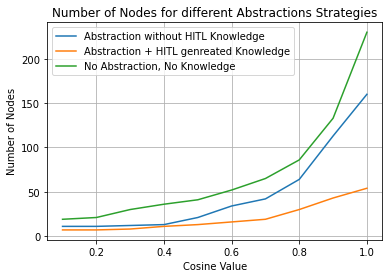

In [7]:
from curses import raw
import matplotlib.pyplot as plt
cosine_ts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
abstraction_with_knowledge = [7,7,8,11,13,16,19,30,43,54]
abstraction_without_knowledge = [11,11,12,13,21,34,42,64,113,160]
raw_data                      = [19,21,30,36,41,52,65,86,133,230]
plt.plot(cosine_ts, abstraction_without_knowledge, label = "Abstraction without HITL Knowledge")
plt.plot(cosine_ts, abstraction_with_knowledge, label = "Abstraction + HITL genreated Knowledge")
plt.plot(cosine_ts, raw_data, label = "No Abstraction, No Knowledge")
plt.title('Number of Nodes for different Abstractions Strategies')
plt.xlabel('Cosine Value')
plt.ylabel('Number of Nodes')
plt.grid()
plt.legend()
plt.show()